# Plotting Historical Term Frequencies Using the DPLA API

### Introduction

Measuring how often a word appears in digitized collections gives us a concrete way to see how public interest in a topic rises and falls over time. By querying the DPLA API for the number of times a term appears in each decade, we can get answers for different cultural questions like "When did mentions of “suffrage” surge in public discourse?", or "How has interest in “jazz” changed over the years?"

In this lesson you will learn: 
- How to register for a DPLA API key
- How to store API keys securely 
- How to construct and send queries to the DPLA API
- How to parse the JSON response to get the total document count
- How to iterate through decades and get frequencies
- How to build a dictionary mapping each decade to its DPLA doc count
- How to create a histogram presenting frequency data

For this lesson I will focus on the term *'suffrage'*. You can use any term you want to study a different question.  


### What is the DPLA? What is an API?  

The **Digital Public Library of America (DPLA)** is an online resource that brings together metadata for millions of digitized items like books, photographs, letters, newspapers, and more from libraries, archives, and museums. 

An **API**, or **Application Programming Interface**, is a way for developers to interact with data through code. By using specific URLs and query parameters, they can request data or services, and the server responds with structured data (typically in JSON format)

We will use the DPLA API to retrieve the counts of documents in the Digital Public Library of America referencing a certain term (such as *'suffrage'*) per decade. 


### Install and Import Libraries
We will first need to install 2 different libraries for this lesson. 
- **Requests**: allows us to make HTTP requests to the API
- **Matplotlib**: allows us to create our histograms

These libraries also need to be imported. We will also import the os library, but it does not need to be installed because it is a standard Python module.

In [2]:
%pip install requests
%pip install matplotlib

import os
import requests
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Obtaining a DPLA API key

The DPLA API requires you to provide an API key which uniquely identifies yourself to them. In order to complete this lesson, you will need to request an API key from them. To get a key, you will send them a post request with your email. 

In the code below you need to replace the **[YOUR EMAIL GOES HERE]** with your actual email. After running the code, you will receive an email with your new API key.

In [ ]:
email = "[YOUR EMAIL GOES HERE]"

requests.post(f"https://api.dp.la/v2/api_key/{email}")

<Response [400]>

### Storing Your Key

It is important to keep your API key safe from prying eyes. Assuming you are following this lesson in your own codespace in github, we can use codespace secrets to keep our key secret. 

- On Github, navigate to your settings by clicking your profile picture in the top right corner and click *Settings*. 
- In the sidebar on the right, click *Codespaces* under *Code, planning, and automation*
- Next to *Codespaces Secrets* click *New Secret*.
- Give the secret the name **DPLA_API_KEY**, and paste in the key from your email.
- Under *Repository access*, select the repo that you are working in.
- Click *Add Secret*.

You now have your API key saved as a codespace secret. To retrieve your key, you can use *os.getenv()*, as seen in the code below. 

In [3]:
DPLA_API_KEY = os.getenv("DPLA_API_KEY")

### Querying the DPLA API

Now that we have our API key, we can start querying the DPLA API. 

We will use the request library to send HTTP requests to the DPLA API. HTTP requests are structured very similarly to URLs. 

The DPLA API has different endpoints (or collections of data) that we can access. For this lesson we will be querying the *items* endpoint, since we want to retrieve all of the items that contain a specific term. This *items* endpoint will be a part of our base url.
```python
query = "https://api.dp.la/v2/items"
```

After the base url, we need to include our query parameters which specify what data we want in our response. Their query parameters are in the form of key/value pairs after a **?** in the url. 

Before we can start narrowing our query, we need to include our API key. This is also a key/value pair, with the key being 'api_key'. So we will begin building up our full query using the key:
```python
query = "https://api.dp.la/v2/items?api_key={DPLA_API_KEY}"
```

As a reminder, the goal of this lesson is to find the count of documents referencing a certain term throughout different decades. So our first query parameter will specify our term. So in addition to the base url, we will also include  `?q={term}` , depending on the term you want to use. So our query now is:
```python
query = "https://api.dp.la/v2/items?api_key={DPLA_API_KEY}?q={term}"
```

Let's try querying the API with this initial query. To do so we will have to send a *get* request. As mentioned before, the term I will be studying is *'suffrage'*, so I will create a term variable containing it to use in my query. 

In [21]:
term = "suffrage"
query = f"https://api.dp.la/v2/items?api_key={DPLA_API_KEY}&q={term}"

From here, we must pass our query in the request, which will be sent to the DPLA API, and we will get our resulting data back. We will use 
 `response.json()`  to get the response in a readable json format. 

Try sending our query and take a look at the response received. 

In [22]:
response = requests.get(query)
response.json()

{'count': 16617,
 'docs': [{'@context': 'http://dp.la/api/items/context',
   '@id': 'http://dp.la/api/items/fa08af04eedbbc80f7f131db5417bc6b',
   '@type': 'ore:Aggregation',
   'aggregatedCHO': '#sourceResource',
   'dataProvider': {'name': 'Harvard University'},
   'id': 'fa08af04eedbbc80f7f131db5417bc6b',
   'ingestDate': '2020-06-26T02:25:17.862Z',
   'ingestType': 'item',
   'isShownAt': 'http://catalog.hathitrust.org/Record/011537121',
   'object': 'https://books.google.com/books/content?id=jXfveeCpYBAC&printsec=frontcover&img=1&zoom=5&edge=curl',
   'originalRecord': {'stringValue': '<record \nxmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.loc.gov/MARC21/slim">\n  <leader>00678cam a22002171 4500</leader>\n  <controlfield tag="001">011537121</controlfield>\n  <controlfield tag="003">MiAaHDL</controlfield>\n  <controlfield tag="005">20120529000000.0</controlfield>\n  <controlfield tag="006">m d </controlfield>\n  <controlfield tag="007">cr bn ---auaua</cont

Now we need to specify the date range of the returned documents. To do this, we can add query parameters to specify the dates of the documents. As you can see in the response you got before, this date information is inside of the *sourceResource* value, so we will need to specify this as well in our query. We will need to get the documents with dates after the start year of the decade (e.g. 1940 for the 1940s), and documents with dates before the end year of the decade (e.g. 1949 for the 1940s). Let's add this to our query:
```python
query = f"https://api.dp.la/v2/items
            ?api_key={DPLA_API_KEY}
            &q={term}
            &sourceResource.date.after={start_year}
            &sourceResource.date.before={end_year}"
```

Go ahead and try this new query:

In [23]:
term = "suffrage"
start_year = 1940
end_year = 1949

query = f"https://api.dp.la/v2/items?api_key={DPLA_API_KEY}&q={term}&sourceResource.date.after={start_year}&sourceResource.date.before={end_year}"
response = requests.get(query)
response.json()

{'count': 64,
 'docs': [{'@context': 'http://dp.la/api/items/context',
   '@id': 'http://dp.la/api/items/4a6f7a6a6c56c82023de9295a33bddd2',
   '@type': 'ore:Aggregation',
   'aggregatedCHO': '#sourceResource',
   'dataProvider': {'@id': 'http://dp.la/api/contributor/boston-public-library',
    'exactMatch': ['http://www.wikidata.org/entity/Q894583'],
    'name': 'Boston Public Library'},
   'id': '4a6f7a6a6c56c82023de9295a33bddd2',
   'iiifManifest': 'https://ark.digitalcommonwealth.org/ark:/50959/9z905q90j/manifest',
   'ingestDate': '2025-01-29T20:24:29.712Z',
   'ingestType': 'item',
   'isShownAt': 'https://ark.digitalcommonwealth.org/ark:/50959/9z905q90j',
   'object': 'https://ark.digitalcommonwealth.org/ark:/50959/9z905q90j/thumbnail',
   'originalRecord': {'stringValue': '<record \nxmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n  <header>\n    <identifier>oai:digitalcommonwealth.org:commonwealth:9z905q90j</identifier>\n    <

Now that we have learned how to build a query, let's turn this into a function that we can call to get the counts per decade. Our function will take our search term and return a dictionary containing each decade between 1800 and 2000 and it's count of documents with the term.

We start by making a dictionary `decade_counts_dict` that will hold our resulting counts. We will need to loop through each decade, so we will create a for loop moving through the range 1800 to 2010 (exclusive), going up by 10 each iteration. 

Then in each decade loop, we can get our start_date and end_date, craft our query as we did before, and send our request. We can also add a check in to see what the response status code is, and print the code if its not 200 (OK) in case something went wrong during our request.

From there, we can get the json response and then get the response count using `resp_json.get("count")`, which returns the number of documents returned by the query (which is exactly what we want!)

Finally we can add this count to our dictionary, using the decade as the key, and count as the value. 

In [27]:
def get_counts(term):
    decade_counts_dict = {}

    for decade in range(1800, 2010, 10):
        start_year = decade
        end_year = decade + 9

        query = f"https://api.dp.la/v2/items?api_key={DPLA_API_KEY}&q={term}&sourceResource.date.after={start_year}&sourceResource.date.before={end_year}"
        
        response = requests.get(query)
        
        if response.status_code != 200:
            print(f"Response status code: {response.status_code}")
            
        resp_json = response.json()
        count = resp_json.get("count")
        decade_counts_dict[decade] = count
    
    return decade_counts_dict

We are now able to get out term counts per decade! Let's call our function and see what it returns:

In [28]:
term = "suffrage"
decade_counts = get_counts(term)
print(decade_counts)


{1800: 18, 1810: 21, 1820: 24, 1830: 43, 1840: 96, 1850: 115, 1860: 270, 1870: 367, 1880: 269, 1890: 414, 1900: 686, 1910: 1201, 1920: 2068, 1930: 156, 1940: 64, 1950: 119, 1960: 182, 1970: 244, 1980: 99, 1990: 39, 2000: 101}


### Plotting Term Counts

We want to do more than just see the counts themselves. Our results would be much more impactful if they were graphed. 

Let's make a function to plot our counts as a histogram. We need to turn our dictionary into lists of the decades and counts per decade. 

We will use the Matplotlib library that we imported earlier as *plt*. Create a figure of whatever size you would like, I did 12x6. We need to create bars for our histogram using the decades and values, with a bar size and color of your choice, I went with 5 and purple respectively. Then label the axes, set the X axis ticks, and show our plot.


In [33]:
def plot_counts(term, decade_counts):
    decades = list(decade_counts.keys())
    values  = list(decade_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(decades, values, 5, color='purple')
    plt.title(f"DPLA Items by Decade: '{term.capitalize()}'")
    plt.xlabel("Decade")
    plt.ylabel("Number of Items")
    plt.xticks(decades, decades)
    plt.tight_layout()
    plt.show()

Let's call our plotting function and see our results!

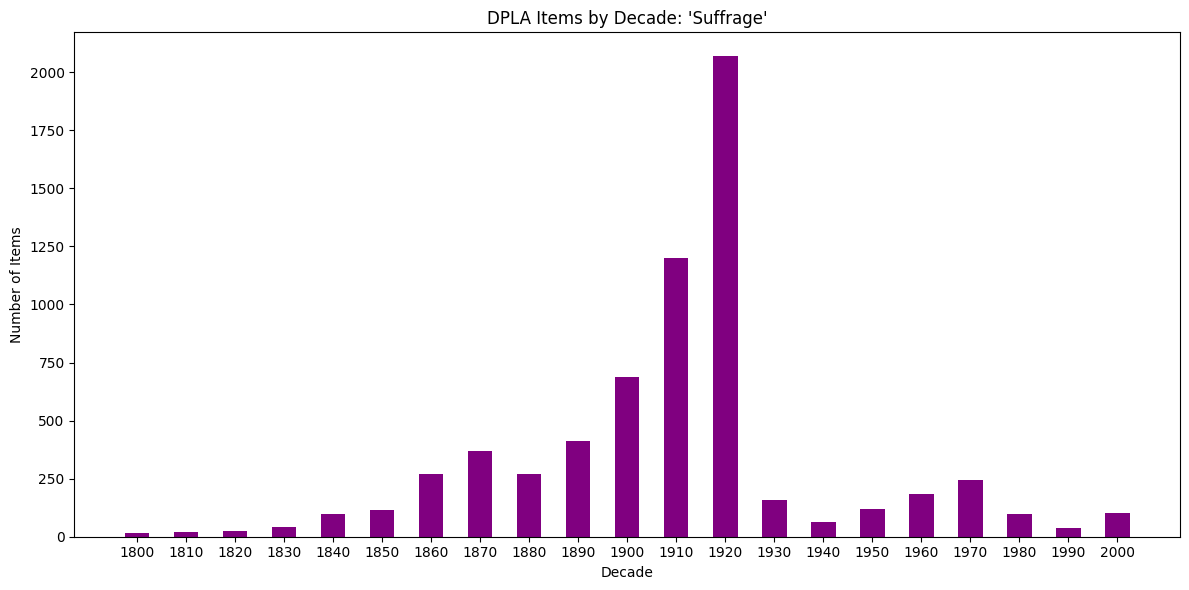

In [34]:
plot_counts(term, decade_counts)

Now we have a visual representation of our documents counts per decade. This graph allows us to analyze trends or cultural shifts surrounding certain terms. If you followed along using my term *'suffrage'*, you can see clearly in the graph that the frequency increased steadily until a dramatic spike in the 1920s, which follows along with the amplification of the women's suffrage movement until the ratification of the 19th Amendment in 1920. 

### Conclusion

By automating term-frequency counts over the years, you can transform millions of scattered records into a clear timeline that reflects public interest. This process offers evidence of when certain topics gained or lost cultural significance. It can track any term, from those related to technology, social movements, historical events, etc, providing you with a data-driven perspective on historical shifts. You can use it to test your theories, uncover trends, or even compare different terms side by side. 